# Order Book Pricing Test: Real Market Dynamics

This notebook demonstrates how **Order Book markets** work (like Kalshi/Polymarket) and shows **price evolution over time**.


In [1]:
%matplotlib inline

import sys
from pathlib import Path

notebook_dir = Path().absolute()
project_root = notebook_dir.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from src.prediction_market_sim.market.orderbook import OrderBookMarket

output_dir = project_root / 'orderbook_test'
output_dir.mkdir(exist_ok=True)
print('✅ Setup complete')
print(f'📁 Working from: {project_root}')


✅ Setup complete
📁 Working from: /Users/ivansit/Desktop/Prediction-Market-Agents-Simulations


## Create Order Book Market

Order books work differently than LMSR:
- Orders need counterparties
- Bid-ask spread exists
- Orders can FAIL


In [2]:
# Create order book with initial liquidity
market = OrderBookMarket(
    market_id='orderbook_test',
    outcomes=['YES', 'NO'],
    tick_size=0.01,
    initial_liquidity=True
)

print('📗 Order Book Market Created')
state = market.get_market_state()
print(f"Best Bid: ${state.get('best_bid', 0):.2f}")
print(f"Best Ask: ${state.get('best_ask', 0):.2f}")
print(f"Spread: ${state.get('spread', 0):.4f}")


📗 Order Book Market Created
Best Bid: $0.49
Best Ask: $0.51
Spread: $0.0200


## Simulate Trading & Track Prices


In [3]:
# Trading sequence
trades = [
    ('BUY', 10, 0.51), ('BUY', 15, 0.52), ('SELL', 5, 0.50),
    ('BUY', 20, 0.53), ('SELL', 10, 0.52), ('BUY', 10, 0.54),
    ('SELL', 15, 0.51), ('BUY', 25, 0.55), ('SELL', 8, 0.53),
    ('BUY', 12, 0.56)
] * 3

# Track prices
timesteps, prices = [0], [0.50]
executed, failed = [], []

print(f'Submitting {len(trades)} orders...\n')

for i, (side, qty, price) in enumerate(trades, 1):
    order = market.submit_limit_order(
        agent_id=f'trader_{i%5}',
        outcome='YES',
        side=side,
        price=price,
        quantity=qty,
        timestamp=i
    )
    
    if order and order.filled_quantity > 0:
        executed.append({'timestep': i, 'side': side, 'price': price})
    else:
        failed.append({'timestep': i, 'side': side, 'price': price})
    
    last_price = market.get_last_price('YES') or 0.50
    timesteps.append(i)
    prices.append(last_price)
    
    if i % 10 == 0:
        print(f'After {i}: Price=${last_price:.4f}, Executed={len(executed)}, Failed={len(failed)}')

print(f'\n✅ Complete! Final Price: ${prices[-1]:.4f}')


Submitting 30 orders...

After 10: Price=$0.5000, Executed=9, Failed=1
After 20: Price=$0.5000, Executed=19, Failed=1
After 30: Price=$0.5000, Executed=29, Failed=1

✅ Complete! Final Price: $0.5000


## Visualize Price Evolution


✅ Saved plot


/var/folders/vq/lkyht8f53ydbr6yjq72tywv40000gn/T/ipykernel_56101/2033373743.py:30: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vq/lkyht8f53ydbr6yjq72tywv40000gn/T/ipykernel_56101/2033373743.py:30: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/vq/lkyht8f53ydbr6yjq72tywv40000gn/T/ipykernel_56101/2033373743.py:31: UserWarning: Glyph 9989 (\N{WHITE HEAVY CHECK MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / 'price_evolution.png', dpi=150, bbox_inches='tight')
/var/folders/vq/lkyht8f53ydbr6yjq72tywv40000gn/T/ipykernel_56101/2033373743.py:31: UserWarning: Glyph 10060 (\N{CROSS MARK}) missing from font(s) DejaVu Sans.
  plt.savefig(output_dir / 'price_evolution.png', dpi=150, bbox_inches='tight')
/Users/ivansit/Desktop/Prediction-Market-Agents-Simulations/venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: G

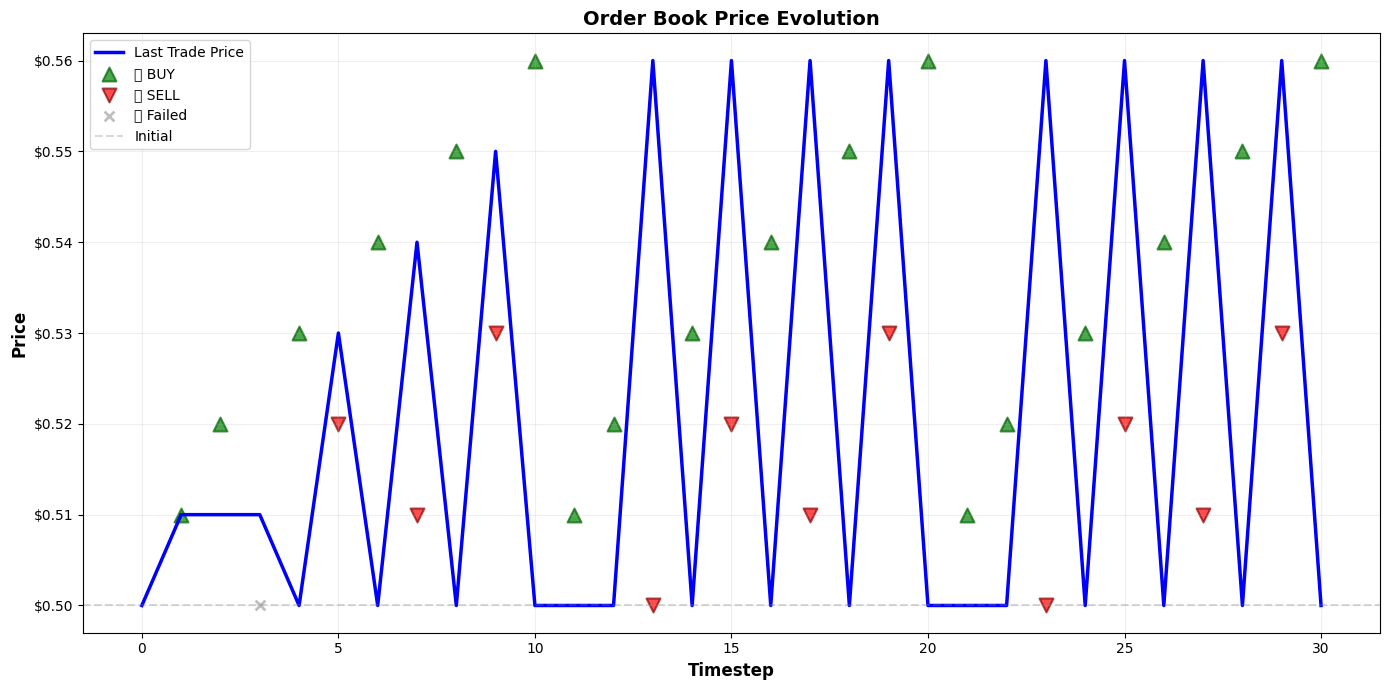

In [4]:
fig, ax = plt.subplots(figsize=(14, 7))

# Plot price evolution
ax.plot(timesteps, prices, 'b-', linewidth=2.5, label='Last Trade Price')

# Mark executed orders
if executed:
    exec_df = pd.DataFrame(executed)
    buys = exec_df[exec_df['side'] == 'BUY']
    sells = exec_df[exec_df['side'] == 'SELL']
    ax.scatter(buys['timestep'], buys['price'], color='green', s=100, marker='^', 
               label='✅ BUY', alpha=0.7, edgecolors='darkgreen', linewidth=1.5)
    ax.scatter(sells['timestep'], sells['price'], color='red', s=100, marker='v',
               label='✅ SELL', alpha=0.7, edgecolors='darkred', linewidth=1.5)

# Mark failed orders
if failed:
    fail_df = pd.DataFrame(failed)
    ax.scatter(fail_df['timestep'], fail_df['price'], color='gray', s=50, 
               marker='x', label='❌ Failed', alpha=0.5, linewidth=2)

ax.axhline(0.50, color='gray', linestyle='--', alpha=0.3, label='Initial')
ax.set_xlabel('Timestep', fontsize=12, fontweight='bold')
ax.set_ylabel('Price', fontsize=12, fontweight='bold')
ax.set_title('Order Book Price Evolution', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.2)
ax.legend(loc='upper left')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'${y:.2f}'))

plt.tight_layout()
plt.savefig(output_dir / 'price_evolution.png', dpi=150, bbox_inches='tight')
print('✅ Saved plot')
plt.show()


## Summary & Key Takeaways


In [5]:
print('='*60)
print('ORDER BOOK RESULTS')
print('='*60)
print(f'Total Orders: {len(trades)}')
print(f'Executed: {len(executed)} ({len(executed)/len(trades)*100:.1f}%)')
print(f'Failed: {len(failed)} ({len(failed)/len(trades)*100:.1f}%)')
print(f'\nInitial Price: ${prices[0]:.4f}')
print(f'Final Price: ${prices[-1]:.4f}')
print(f'Change: ${prices[-1] - prices[0]:+.4f}')
print('='*60)
print('\n🎯 Key Insight: Order books have REALISTIC behavior')
print('   - Some orders execute')
print('   - Some orders fail (no counterparty)')
print('   - Just like Kalshi/Polymarket!')

# Save results
df = pd.DataFrame({'timestep': timesteps, 'price': prices})
df.to_csv(output_dir / 'price_data.csv', index=False)
print(f'\n✅ Saved: {output_dir / "price_data.csv"}')


ORDER BOOK RESULTS
Total Orders: 30
Executed: 29 (96.7%)
Failed: 1 (3.3%)

Initial Price: $0.5000
Final Price: $0.5000
Change: $+0.0000

🎯 Key Insight: Order books have REALISTIC behavior
   - Some orders execute
   - Some orders fail (no counterparty)
   - Just like Kalshi/Polymarket!

✅ Saved: /Users/ivansit/Desktop/Prediction-Market-Agents-Simulations/orderbook_test/price_data.csv
